<a href="https://colab.research.google.com/github/nitinaarora/NLP-Attention/blob/master/nmt_with_attention_self_18Sept_integrate_withSpider.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### data from Spider and processing

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [2]:
pip install -q kaggle

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d jeromeblanchet/yale-universitys-spider-10-nlp-dataset

 76% 73.0M/96.0M [00:00<00:00, 56.1MB/s]
100% 96.0M/96.0M [00:00<00:00, 104MB/s] 


In [7]:
!unzip yale-universitys-spider-10-nlp-dataset.zip

Archive:  yale-universitys-spider-10-nlp-dataset.zip
  inflating: spider/README.txt       
  inflating: spider/database/academic/academic.sqlite  
  inflating: spider/database/academic/schema.sql  
  inflating: spider/database/activity_1/activity_1.sqlite  
  inflating: spider/database/activity_1/schema.sql  
  inflating: spider/database/aircraft/aircraft.sqlite  
  inflating: spider/database/aircraft/schema.sql  
  inflating: spider/database/allergy_1/allergy_1.sqlite  
  inflating: spider/database/allergy_1/schema.sql  
  inflating: spider/database/apartment_rentals/apartment_rentals.sqlite  
  inflating: spider/database/apartment_rentals/schema.sql  
  inflating: spider/database/architecture/architecture.sqlite  
  inflating: spider/database/architecture/schema.sql  
  inflating: spider/database/assets_maintenance/assets_maintenance.sqlite  
  inflating: spider/database/assets_maintenance/schema.sql  
  inflating: spider/database/baseball_1/baseball_1.sqlite  
  inflating: spider/da

In [8]:
df2 = pd.read_json('/content/spider/dev.json')

In [9]:
df2['question']
df2['query']

0                             SELECT count(*) FROM singer
1                             SELECT count(*) FROM singer
2       SELECT name ,  country ,  age FROM singer ORDE...
3       SELECT name ,  country ,  age FROM singer ORDE...
4       SELECT avg(age) ,  min(age) ,  max(age) FROM s...
                              ...                        
1029    SELECT Citizenship FROM singer WHERE Birth_Yea...
1030        SELECT count(*) FROM Other_Available_Features
1031    SELECT T2.feature_type_name FROM Other_Availab...
1032    SELECT T2.property_type_description FROM Prope...
1033    SELECT property_name FROM Properties WHERE pro...
Name: query, Length: 1034, dtype: object

In [41]:
df2['question'] = '<start> '+ df2['question'] + ' <end>'

In [42]:
df2['question']

0              <start> How many singers do we have? <end>
1       <start> What is the total number of singers? <...
2       <start> Show name, country, age for all singer...
3       <start> What are the names, countries, and age...
4       <start> What is the average, minimum, and maxi...
                              ...                        
1029    <start> What are the citizenships that are sha...
1030    <start> How many available features are there ...
1031    <start> What is the feature type name of featu...
1032    <start> Show the property type descriptions of...
1033    <start> What are the names of properties that ...
Name: question, Length: 1034, dtype: object

In [43]:
df2['query'] ='<start> '+ df2['query'] + ' <end>'

In [44]:
question_dataset =[]
query_dataset =[]

question_dataset= df2['question']
query_dataset = df2['query']

In [11]:
def tokenize(lang):
  #lang ='Nitin'
  lan_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='') 
  # we are giving filters here so that nothing get filter out..as by default all panchuation could be filtered out
  lan_tokenizer.fit_on_texts(lang)
  tensor = lan_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, 
                                                         padding='post')
  return tensor,lan_tokenizer

In [12]:
def load_spider_dataset(question,query):
  # creating cleaned input, output pairs

  input_tensor, inp_lang_tokenizer = tokenize(question)
  target_tensor, targ_lang_tokenizer = tokenize(query)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [45]:

input_tensor, target_tensor, inp_lang, targ_lang = load_spider_dataset(question_dataset, query_dataset)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [46]:
#now lets create dataset

BUFFER_SIZE = len(input_tensor)
#print(BUFFER_SIZE)
BATCH_SIZE=64
steps_per_epoch = len(input_tensor)//BATCH_SIZE
print(steps_per_epoch)
embedding_dim = 256
units = 1024

vocab_input_size = len(inp_lang.word_index) +1 # need to understand why +1
vocab_target_size = len(targ_lang.word_index) +1 # need to understand why +1
print(vocab_input_size)
print(vocab_target_size)

dataset = tf.data.Dataset.from_tensor_slices((input_tensor,target_tensor)).shuffle(BUFFER_SIZE)
print(dataset)
dataset = dataset.batch(BATCH_SIZE, drop_remainder = True)
print(dataset)

16
1419
895
<ShuffleDataset shapes: ((30,), (60,)), types: (tf.int32, tf.int32)>
<BatchDataset shapes: ((64, 30), (64, 60)), types: (tf.int32, tf.int32)>


In [15]:
failed


NameError: ignored

468
9414
4935
<ShuffleDataset shapes: ((16,), (11,)), types: (tf.int32, tf.int32)>
<BatchDataset shapes: ((64, 16), (64, 11)), types: (tf.int32, tf.int32)>

####Steps

1. get data from storage
2. remove ASCII, special characters
3. clean data
  3.1 add START and END to each sentence
  3.2 padding 
  3.3 
4. make function to create database, load database, tokenizer
5. create encoder
6. create decoder
7. create attention function
8. create run_step function
9. train model






In [16]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [ ]:
# Download the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

In [ ]:
print(path_to_file)

In [64]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [ ]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))
print(preprocess_sentence(sp_sentence))


In [ ]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [ ]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

In [ ]:
def tokenize(lang):
  #lang ='Nitin'
  lan_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='') 
  # we are giving filters here so that nothing get filter out..as by default all panchuation could be filtered out
  lan_tokenizer.fit_on_texts(lang)
  tensor = lan_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, 
                                                         padding='post')
  return tensor,lan_tokenizer

In [ ]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [ ]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [ ]:
print(target_tensor.shape)
print(input_tensor.shape)
print(max_length_inp)

In [ ]:
print(target_tensor[1])

In [ ]:
print(inp_lang.word_index)

In [47]:
#now lets create dataset

BUFFER_SIZE = len(input_tensor)
#print(BUFFER_SIZE)
BATCH_SIZE=64
steps_per_epoch = len(input_tensor)//BATCH_SIZE
print(steps_per_epoch)
embedding_dim = 256
units = 1024

vocab_input_size = len(inp_lang.word_index) +1 # need to understand why +1
vocab_target_size = len(targ_lang.word_index) +1 # need to understand why +1
print(vocab_input_size)
print(vocab_target_size)

dataset = tf.data.Dataset.from_tensor_slices((input_tensor,target_tensor)).shuffle(BUFFER_SIZE)
print(dataset)
dataset = dataset.batch(BATCH_SIZE, drop_remainder = True)
print(dataset)

16
1419
895
<ShuffleDataset shapes: ((30,), (60,)), types: (tf.int32, tf.int32)>
<BatchDataset shapes: ((64, 30), (64, 60)), types: (tf.int32, tf.int32)>


In [48]:
example_input_batch, example_target_batch = next(iter(dataset)) ## its imp to note as this is how we navigate in dataset
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 30]), TensorShape([64, 60]))

In [ ]:
dataset.cardinality() # this is imp as its tell how many batches we are going to get

In [17]:
#now create encoder
#should have :- 1) embedding layer, 2) LSTm/RNN layer with return_sequence = false and 3) return_state = True, output of this should go to decoder
# now because we are using attention model directly, return_sequence can be True, lets see
class Encoder(tf.keras.Model):
  def __init__(self,vocab_size, embedding_dim, enc_unit,batch_sz): ## constructor
    super(Encoder,self).__init__()
    self.batch_sz = batch_sz
    self.enc_unit = enc_unit
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_unit,
                                   return_sequences =True,
                                   return_state = True,
                                   recurrent_initializer ='glorot_uniform') ## need toc heck use of this recurrent_initializer
  def call(self,x,hidden):
    x = self.embedding(x)
    output,state = self.gru(x, initial_state = hidden)
    return output,state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_unit))



In [49]:
#lets test this encoder
encoder = Encoder(vocab_input_size,embedding_dim,units,BATCH_SIZE)


In [50]:
#encoder(x,hidden)
sample_hidden = encoder.initialize_hidden_state()

encoder_output, encoder_state = encoder( example_input_batch,sample_hidden)

In [51]:
print(encoder_output.shape)
print(encoder_state.shape)

(64, 30, 1024)
(64, 1024)


In [52]:
class Battention(tf.keras.layers.Layer):
  def __init__(self,units):
    super(Battention,self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self,query,values):
    #now this query is hidden state so shape would be batch, hidden_Size/hidden_units..ie. 64 *1024
    #values shape would be batch, max_length, and hidden units
    # we need to have shape same, so would expand query one now
    # one of them (query, values) would be decoder hiddent state and another would be Encoder hiddem state"S"
    # from below ----values seems encoder hidden states whereas query seems decoder previous hiddent state
    # query===Hidden
    query_with_time_axis = tf.expand_dims(query,1)
    # remember score get calculated with help of previous decoder hidden state PLUS all hinned states of encoder AND then vectorised it for all sequence
    # in that way vector length would be same as input sequence of encoder
    score = self.V(tf.nn.tanh
                   (self.W1(query_with_time_axis) +
                    self.W2(values)
                   ))
    
    attention_weights = tf.nn.softmax(score, axis=1)

    # contect vector would be multolication of encoder hidden state with attention weights
    # so it means "values" represent encoder hidden states
    # so in that case we get answer of upper question

    context_vector = attention_weights*values
    context_vector = tf.reduce_sum(context_vector, axis=1)
    #reduce_sum function reduce dimension (x =0) means row reduce, x=1 means column reduced
    # so here we reduced columns dimension
    #source https://stackoverflow.com/questions/47157692/how-does-reduce-sum-work-in-tensorflow
    return context_vector, attention_weights


In [53]:
attention_layer = Battention(10)
c_vector, att_weights = attention_layer(sample_hidden, encoder_output)

In [ ]:
print(c_vector.shape)
print(att_weights.shape)

In [54]:
class Decoder (tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units,batch_sz):
    super(Decoder,self).__init__()
    self.embedding = tf.keras.layers.Embedding(vocab_size,embedding_dim)
    self.gru = tf.keras.layers.GRU(
        dec_units,
        return_sequences = True,
        return_state = True,
        recurrent_initializer = 'glorot_uniform')
    self.FC = tf.keras.layers.Dense(vocab_size)

    self.attention = Battention(dec_units) #only instatiation here

  def call(self,x,hidden,enc_output):
    context_vector, attention_weights = self.attention(hidden, enc_output ) ## here i have doubt about second paramater. As per my understanding it should be enoder hidden state (not encoder_output)
    x= self.embedding(x)
    #now concatenate this value with context-vector and then feed into GRU
    x = tf.concat([tf.expand_dims(context_vector,1),x],axis =-1)
    output, state = self.gru(x)
    #reshape this output and pass it to FC
    output = tf.reshape(output, (-1, output.shape[2]))
    x= self.FC(output)
    return x, state,attention_weights


In [55]:
#test this now

decoder = Decoder(vocab_target_size,embedding_dim,1024,64)
sample_decoder_output, _,_= decoder(tf.random.uniform((BATCH_SIZE,1)),
                                    encoder_state,
                                    encoder_output)

In [56]:
# need to understand why we need loss_function method
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [57]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [58]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [68]:
EPOCHS = 100

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.4431
Epoch 1 Loss 0.4701
Time taken for 1 epoch 5.218837738037109 sec

Epoch 2 Batch 0 Loss 0.4362
Epoch 2 Loss 0.4427
Time taken for 1 epoch 5.504639387130737 sec

Epoch 3 Batch 0 Loss 0.4483
Epoch 3 Loss 0.4204
Time taken for 1 epoch 5.1831889152526855 sec

Epoch 4 Batch 0 Loss 0.3977
Epoch 4 Loss 0.3995
Time taken for 1 epoch 5.534530162811279 sec

Epoch 5 Batch 0 Loss 0.3576
Epoch 5 Loss 0.3709
Time taken for 1 epoch 5.205682754516602 sec

Epoch 6 Batch 0 Loss 0.3426
Epoch 6 Loss 0.3431
Time taken for 1 epoch 5.52851676940918 sec

Epoch 7 Batch 0 Loss 0.3243
Epoch 7 Loss 0.3144
Time taken for 1 epoch 5.166582822799683 sec

Epoch 8 Batch 0 Loss 0.2904
Epoch 8 Loss 0.2901
Time taken for 1 epoch 5.502891540527344 sec

Epoch 9 Batch 0 Loss 0.2976
Epoch 9 Loss 0.2754
Time taken for 1 epoch 5.190189838409424 sec

Epoch 10 Batch 0 Loss 0.2592
Epoch 10 Loss 0.2447
Time taken for 1 epoch 5.510366201400757 sec

Epoch 11 Batch 0 Loss 0.2096
Epoch 11 Loss 0.2188
Time tak

In [60]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [61]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [62]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [87]:
print(df2['question'][100])


<start> What is the name of the different car makers who produced a car in 1970? <end>


Input: <start> what is the name of the different car makers who produced a car in <end>
Predicted translation: select distinct t1.maker from car_makers as t1 join model_list as t2 on t1.id = t2.maker group by t1.id having count(*) >= 2 intersect select distinct t1.maker from car_makers as t1 join model_list as t2 on t1.id = t2.maker group by t1.id having count(*) >= 2 intersect select distinct t1.maker from car_makers as t1 join model_list as t2 on t1.id = 


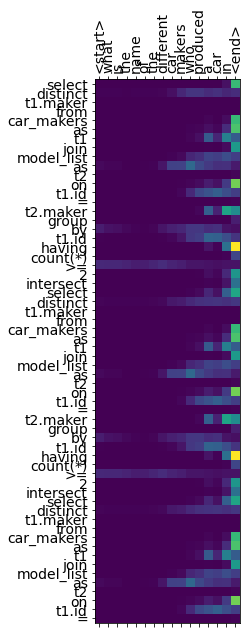

In [88]:
translate(u'What is the name of the different car makers who produced a car in 1970')